Flash data has not be read in yet. Reading now.
2023-05-11 23:38:29
Count of flashes =  5
Flash areas (km^2):  10618     2.144109
10622    35.200020
10625     0.416633
10638     0.213062
10651     3.972658
Name: area, dtype: float32
Flash durations (s):  10618    0.185019
10622    0.381701
10625    0.074147
10638    0.105583
10651    0.177415
Name: duration, dtype: float32


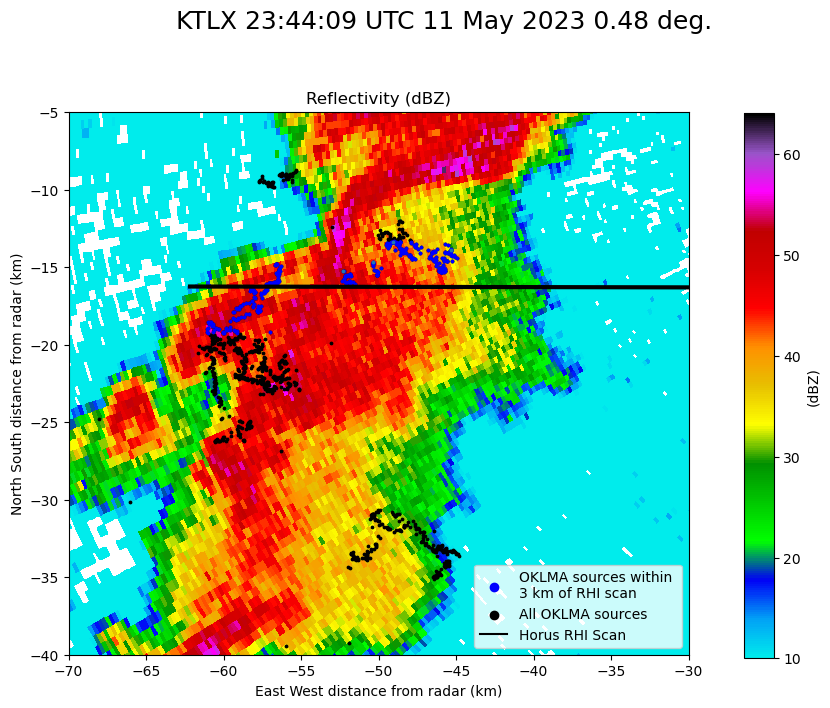

In [2]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pyart
from pyart.config import get_metadata
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from pyart.config import get_metadata
from scipy.io import loadmat
import datetime as dt
from datetime import datetime, timedelta

# Imports for LMA data
from pyxlma.lmalib.io import read as lma_read
import glob
import pandas as pd
from scipy import spatial

def ingest_mat(filename):
    r_data = loadmat(filename)

    resolution = r_data['cut']['prod'][0][0][0][0][2][0,0]
    [num_bins, num_rads] = np.shape(r_data['cut']['prod'][0][0][0][3][-1])
    ranges = np.arange(1,num_bins+1) * resolution + r_data['cut']['start_range_km'][0,0][0,0]
    
    radar = pyart.testing.make_empty_rhi_radar(np.shape(r_data['cut']['prod'][0][0][0][0][-1])[0],
                                               np.shape(r_data['cut']['prod'][0][0][0][0][-1])[1], 1)

    radar.latitude["data"]  = r_data['cut']['lat'][0,0][0]
    radar.longitude["data"] = r_data['cut']['lon'][0,0][0]
    radar.range["data"]     = ranges
    radar.altitude["data"]  = (r_data['cut']['elev_m']+
                               r_data['cut']['height_m'])[0,0][0]
    radar.azimuth["data"]   = r_data['cut']['az_deg'][0,0][0]
    radar.elevation["data"] = r_data['cut']['el_deg'][0,0][0]
    radar.sweep_number["data"] = np.zeros_like(r_data['cut']['prod'][0,0][0,0][-1])

    # Create gate lat, lon and alt
    radar.init_gate_altitude()
    radar.init_gate_longitude_latitude()
    
    ref_dict = get_metadata("reflectivity")
    ref_dict["data"] = r_data['cut']['prod'][0,0][0,0][-1].T

    vel_dict = get_metadata("velocity")
    vel_dict["data"] = r_data['cut']['prod'][0,0][0,1][-1].T

    spe_dict = get_metadata("spectrum_width")
    spe_dict["data"] = r_data['cut']['prod'][0,0][0,2][-1].T

    zdr_dict = get_metadata("differential_reflectivity")
    zdr_dict["data"] = r_data['cut']['prod'][0,0][0,3][-1].T

    phi_dict = get_metadata("differential_phase")
    phi_dict["data"] = r_data['cut']['prod'][0,0][0,4][-1].T

    rho_dict = get_metadata("cross_correlation_ratio")
    rho_dict["data"] = np.abs(r_data['cut']['prod'][0,0][0,5][-1].T)

    snr_dict = get_metadata("signal_to_noise_ratio")
    snr_dict["data"] = 10*np.log10(r_data['cut']['prod'][0,0][0,6][-1].T)
    
    radar.fields = {"reflectivity":ref_dict,
                    "velocity":vel_dict,
                    "spectrum_width":spe_dict,
                    "differential_reflectivity":zdr_dict,
                    "differential_phase":phi_dict,
                    "cross_correlation_ratio":rho_dict,
                    "signal_to_noise_ratio":snr_dict,
                   }
    return radar

filename = '/Users/1890500/Desktop/School Work/Radar/Python/Data (MATLAB)/1/A/HRUS_230511_233831000_100_RHI_AZ_270.mat'
radardata = ingest_mat(filename)

try:
    radar_time = dt.datetime.strptime('-'.join(filename.split('/')[-1].split('_')[1:3]),'%y%m%d-%H%M%S%f')
except ValueError:
    radar_time = dt.datetime.strptime(filename.split('/')[-1].split('_')[1],'%y%m%d'
                    )+dt.timedelta(hours=int(filename.split('/')[-1].split('_')[2][:2])
                    )+dt.timedelta(minutes=int(filename.split('/')[-1].split('_')[2][2:4])
                    )+dt.timedelta(seconds=int(filename.split('/')[-1].split('_')[2][4:6]))

rx,ry,rz = radardata.get_gate_x_y_z(0)

radar_id="KTLX"

#select KTLX file to plot
file = "/Users/1890500/Desktop/School Work/Radar/Python/xlma-python/20230511_KTLX/KTLX20230511_234409_V06"

radar = pyart.io.read(file)

#set the plot limits (km from radar) - use this to zoom in on certain features
xwest=-70
xeast=-30
ysouth=-40
ynorth=-5

#Define the overall plot:
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=(10, 10))

try:
    radar_time = dt.datetime.strptime('-'.join(filename.split('/')[-1].split('_')[1:3]), '%y%m%d-%H%M%S%f')
except ValueError:
    radar_time = dt.datetime.strptime(filename.split('/')[-1].split('_')[1], '%y%m%d') + \
                 dt.timedelta(hours=int(filename.split('/')[-1].split('_')[2][:2])) + \
                 dt.timedelta(minutes=int(filename.split('/')[-1].split('_')[2][2:4])) + \
                 dt.timedelta(seconds=int(filename.split('/')[-1].split('_')[2][4:6]))

rx, ry, rz = radardata.get_gate_x_y_z(0)

## Set the plotting criteria!
#### Note that these are in 10-minute chunks, so you do not need to execute this cell multiple times if you switch to a different radar file in the same time period
min_stations = 6 # more stations = more confident it's a good solution
max_chi = 1 # lower reduced chi^2 = more confident it's a good solution
tbuffer = 2 # How many seconds around the radar scan time do you want to plot LMA data?
max_dist = 3e3 # meters, max distance of an LMA source to a radar grid centroid to be plotted
transparent = 'False' # True to increase transparency of sources farther from grid centroid
# method = 'cartesian'# 'cartesian' or 'kdtree' 
method = 'kdtree'
# Use method to determine distance for LMA sources
# cartesian = from RHI plane, pure rotated coordinate system
# kdtree = from radar gates, matches to the nearest radar gate 
#    useful for statistical analysis and close match to rotated frame
#    plus removes outside scan angle points

#Set the minimum number of events per flash
min_events_per_flash = 10 # Minimum number of sources per flash

# Set your directory with the LMA files
#H5_dir = '/Users/Cory Schultz/Desktop/Cory/Python/lmatools h5 files/'
H5_dir = '/Users/1890500/Desktop/School Work/Radar/Python/xlma-python/lmatools h5 files/'

# Pull times +/- tbuffer from the radar time (from the file name)
min_t = radar_time-dt.timedelta(seconds=tbuffer)
max_t = radar_time+dt.timedelta(seconds=0)

if 'flash_event_time' in locals():
    if (min_t>=min(flash_event_time))&(
        max_t<=max(flash_event_time)):
        print ('Flash data already in memory')
        pass
    else:
        print ('Flash data in memory for incorrect time. Reading new data now.')
        flashes = pd.DataFrame()
        flash_events = pd.DataFrame()
        # This makes sure to grab files on either side of the radar scan if the radar
        # scan was near the 10-minute interval according to the buffer
        filenames = glob.glob('{}L*{}000_0600.dat.flash.h5'.format(H5_dir,
                     min_t.strftime('%y%m%d_%H%M')[:-1]))
        filenames = filenames + glob.glob('{}L*{}000_0600.dat.flash.h5'.format(H5_dir,
                     max_t.strftime('%y%m%d_%H%M')[:-1]))
        filenames = list(set(filenames))
        for filename in filenames:
            timeobj = dt.datetime.strptime(filename.split('\\')[-1], 
                                           "LYLOUT_%y%m%d_%H%M%S_0600.dat.flash.h5")
            flashes2 = pd.read_hdf(filename,'flashes/LMA_{}00_600'.format(
                                            timeobj.strftime('%y%m%d_%H%M')))
            flash_events2 = pd.read_hdf(filename,'events/LMA_{}00_600'.format(
                                            timeobj.strftime('%y%m%d_%H%M')))
            if flashes.shape[0]>0:
                flashes2.flash_id      = flashes2['flash_id']     +flashes.flash_id.max()+1
                flash_events2.flash_id = flash_events2['flash_id']+flashes.flash_id.max()+1
            else:
                pass
            flashes      = pd.concat([flashes,flashes2])
            flash_events = pd.concat([flash_events,flash_events2])         

else:
    print ('Flash data has not be read in yet. Reading now.')
    print (min_t)
    flashes = pd.DataFrame()
    flash_events = pd.DataFrame()
    # This makes sure to grab files on either side of the radar scan if the radar
    # scan was near the 10-minute interval according to the buffer
    filenames = glob.glob('{}L*{}000_0600.dat.flash.h5'.format(H5_dir,
                 min_t.strftime('%y%m%d_%H%M')[:-1]))
    filenames = filenames + glob.glob('{}L*{}000_0600.dat.flash.h5'.format(H5_dir,
                 max_t.strftime('%y%m%d_%H%M')[:-1]))
    filenames = list(set(filenames))
    for filename in filenames:
        timeobj = dt.datetime.strptime(filename.split('\\')[-1], 
                                       "LYLOUT_%y%m%d_%H%M%S_0600.dat.flash.h5")
        flashes2 = pd.read_hdf(filename,'flashes/LMA_{}00_600'.format(
                                        timeobj.strftime('%y%m%d_%H%M')))
        flash_events2 = pd.read_hdf(filename,'events/LMA_{}00_600'.format(
                                        timeobj.strftime('%y%m%d_%H%M')))
        if flashes.shape[0]>0:
            flashes2.flash_id      = flashes2['flash_id']     +flashes.flash_id.max()+1
            flash_events2.flash_id = flash_events2['flash_id']+flashes.flash_id.max()+1
        else:
            pass
        flashes      = pd.concat([flashes,flashes2])
        flash_events = pd.concat([flash_events,flash_events2])

flash_event_time = np.array([dt.datetime(*min_t.timetuple()[:3])+dt.timedelta(seconds = i) for
                i in flash_events.time])

# Select all the good sources
selection_event = (flash_event_time>=min_t)&(
                   flash_event_time<max_t)&(
                   flash_events.chi2<=max_chi)&(
                   flash_events.stations>=min_stations)

# Pull x,y,z on a radar-centered grid
lma_z = flash_events.alt[selection_event]
lma_x, lma_y = pyart.core.geographic_to_cartesian_aeqd(
                                        flash_events.lon[selection_event].values, 
                                        flash_events.lat[selection_event].values,
                                        radardata.longitude['data'][0], 
                                        radardata.latitude['data'][0], R=6370997.0)

if method == 'kdtree':
    # Convert to range
    cartesian_lma_r = (lma_x**2+lma_y**2)**0.5
    # Define a KD tree of the radar grid points
    radar_tree = spatial.KDTree(np.array([rx.ravel(), 
                                          ry.ravel(), 
                                          rz.ravel()]).T)
    # Look for LMA sources near the radar grid points
    dists, indext = radar_tree.query(np.array([lma_x,lma_y,lma_z]).T)

elif method == 'cartesian':
    az_rad = np.deg2rad(radardata.azimuth["data"][0]-90)
    cartesian_lma_r = lma_x*np.cos(az_rad) - lma_y*np.sin(az_rad) # Cartesian x
    dists           = lma_y*np.cos(az_rad) + lma_x*np.sin(az_rad) # Cartesian y

# Create a new subset and define a color array for plotting
sel2 = np.abs(dists)<max_dist
alpha = np.exp(-np.abs(dists)/(max_dist/3))
if transparent == 'True': c = np.asarray([(0,0,0,a) for a in alpha])[(sel2)]
else: c = np.asarray([(0,0,0,1) for a in alpha])[(sel2)]

#Unique flashes with at least one VHF source meeting the distance and time thresholds from the RHI
# Find flashes with at least one VHF source meeting the distance and time threshold
ids_in_rhi     = flash_events.flash_id[selection_event][sel2]
flashes_in_rhi = flashes.loc[flashes.flash_id.isin(ids_in_rhi.unique())]

print ('Count of flashes = ',np.sum(flashes_in_rhi.n_points>=min_events_per_flash))

# Lots of flashes should relate to small areas and vice versa
print ('Flash areas (km^2): ', 
       flashes_in_rhi.area[flashes_in_rhi.n_points>=min_events_per_flash])

# Small flashes by area are also typically short in duration
print ('Flash durations (s): ', 
        flashes_in_rhi.duration[flashes_in_rhi.n_points>=min_events_per_flash])
#And finally, this is the sum of the unique flashes - might write to a file with the time to keep record or print on the plot, etc
np.sum(flashes_in_rhi.n_points>=min_events_per_flash)

init_time = np.array([dt.datetime(* min_t.timetuple()[:3])+dt.timedelta(seconds = i) for
                i in flashes.start])

# Select all the good sources
selection_flash = (flashes.n_points>=min_events_per_flash)&(
                     init_time>min_t)&(
                     init_time<max_t)

# Pull x,y,z on a radar-centered grid
flash_init_z = flashes.init_alt[selection_flash]
flash_init_x, flash_init_y = pyart.core.geographic_to_cartesian_aeqd(
                                        flashes.init_lon[selection_flash].values, 
                                        flashes.init_lat[selection_flash].values,
                                        radardata.longitude['data'][0], 
                                        radardata.latitude['data'][0], R=6370997.0)

if method == 'kdtree':
    # Convert to range
    cartesian_flash_r = (flash_init_x**2+flash_init_y**2)**0.5
    # If used previously, tree will already be defined
    # Look for LMA sources near the radar grid points
    dists_init, indext_init = radar_tree.query(np.array([flash_init_x, 
                                                         flash_init_y, 
                                                         flash_init_z]).T)

elif method == 'cartesian':
    cartesian_flash_r = flash_init_x*np.cos(az_rad) - flash_init_y*np.sin(az_rad) # Cartesian x
    dists_init        = flash_init_y*np.cos(az_rad) + flash_init_x*np.sin(az_rad) # Cartesian y

# Create a new subset and define a color array for plotting
sel_flash = np.abs(dists_init)<max_dist
alpha_flash = np.exp(-np.abs(dists_init)/(max_dist/3))
if transparent == 'True': c_flash = np.asarray([(0,0,0,a) for a in alpha_flash])[(sel_flash)]
else: c_flash = np.asarray([(0,0,0,1) for a in alpha_flash])[(sel_flash)]

# Pull x,y,z on a radar-centered grid for Horus
flash_init_z = flashes.init_alt[selection_flash]
flash_init_x, flash_init_y = pyart.core.geographic_to_cartesian_aeqd(
                                        flashes.init_lon[selection_flash].values, 
                                        flashes.init_lat[selection_flash].values,
                                        radardata.longitude['data'][0], 
                                        radardata.latitude['data'][0], R=6370997.0)
#Plotting Horus's location in cartesian coordinates
g1_x, g1_y = pyart.core.geographic_to_cartesian_aeqd(-97.44610843033158, 35.18643149981645, 
                                            radar.longitude['data'][0], radar.latitude['data'][0], 
                                            R=6370997.0)
g2_x, g2_y = pyart.core.geographic_to_cartesian_aeqd(-97.96186092857889, 35.18533738520178, 
                                            radar.longitude['data'][0], radar.latitude['data'][0], 
                                            R=6370997.0)

#KTLX Reflectivity Plot
sweep=0
ax = fig.add_subplot(111,aspect='equal')
display.plot('reflectivity',sweep, vmin=10, vmax=64, colorbar_label='(dBZ)', 
             axislabels=('East West distance from radar (km)','North South distance from radar (km)'), 
             cmap='pyart_NWSRef',title='Reflectivity (dBZ)', 
             colorbar_flag=True)
ax.plot([g1_x/1e3, g2_x/1e3],[g1_y/1e3, g2_y/1e3], color='black', linewidth=3)

# Add square marker at HRUS radar location
ax.plot(g1_x/1e3, g1_y/1e3, marker='s', markersize=7, color='red')

display.set_limits((xwest, xeast), (ysouth, ynorth), ax=ax)


#Plot LMA data
plt.scatter((lma_x+g1_x)/1e3,(lma_y+g1_y)/1e3, color='k',s=3) # all sources 
plt.scatter((lma_x+g1_x)[sel2]/1e3,(lma_y+g1_y)[sel2]/1e3, color='b',s=3) # within set range of radar scan
#plt.scatter((rx+g1_x)/1e3,(ry+g1_y)/1e3,color='g',s=1) # radar scan
plt.scatter((flash_init_x+g1_x)[sel_flash]/1e3, (flash_init_y+g1_y)[sel_flash]/1e3,s=3)

# Remove the original color bar if it exists
cbar = None
if len(fig.axes) > 1:
    cbar = fig.axes[-1]
    fig.delaxes(cbar)

# Color bar
cax = fig.add_axes([0.8, 0.22, 0.03, 0.545])  # Specify the color bar position and size
# Adjust the color bar size to match the height of the graph
cbar = plt.colorbar(display.plots[0], cax=cax)
# Add a label to the color bar
cbar.set_label('(dBZ)')

# Add a legend for LMA dot colors and RHI line
lma_legend1 = ax.scatter([], [], c='blue', label='OKLMA sources within \n3 km of RHI scan') 
lma_legend2 = ax.scatter([], [], c='black', label='All OKLMA sources')
rhi_legend = ax.plot([], [], c='black', label='Horus RHI Scan') 
legend_elements = [lma_legend1, lma_legend2, rhi_legend[0]]  # Combine legend elements

# Create the legend
ax.legend(handles=legend_elements, loc='lower right')

#Add a general title
time=pyart.util.datetimes_from_radar(radar)
tstamp=time[radar.sweep_start_ray_index['data'][sweep]]
radar_id = radar.metadata['instrument_name']
angle = radar.fixed_angle['data'][sweep]
angle = radar.fixed_angle['data'][sweep]
title=f'{radar_id} {tstamp:%X} UTC {tstamp:%d} {tstamp:%B} {tstamp:%Y} {angle:.2f} deg.'
fig.text(0.5,0.85,title,horizontalalignment='center',size=18)

#Create output file name based on site and date/time
output_folder = '/Users/1890500/Desktop/School Work/Radar/Python/REU Plots/KTLX Plot/'
outfile = f'{output_folder}PPI_{radar_id}_{tstamp:%Y%M%d}_{tstamp:%H%M}Z_LMA_overlay'
#Save a PNG image of the figure to your plot directory:
plt.savefig(outfile, bbox_inches='tight', pad_inches=0.4)

plt.show()
